In [1]:
import numpy as np
import geopandas as gpd
import rasterio
import joblib
import matplotlib.pyplot as plt

from collections import Counter
from rasterio.transform import from_bounds
from shapely.geometry import mapping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
TRAIN_DIR = '/home/andre/Documentos/SpotSat/data/processed/training/'
VALID_DIR = '/home/andre/Documentos/SpotSat/data/processed/valid/'
OUTPUT_DIR = '/home/andre/Documentos/SpotSat/data/processed/model/'
RASTER_DIR = OUTPUT_DIR + 'raster/'
RASTER_DIR_FILE = RASTER_DIR + 'classification_result.tif'

In [3]:
# 2. Carregamento dos Dados Processados
def load_data(train_dir, valid_dir):
    X_train = np.load(train_dir + 'X_train_processed.npy')
    y_train_gdf = gpd.read_file(train_dir + 'train_gdf_processed.shp')
    y_train = y_train_gdf['LULC'].values

    X_valid = np.load(valid_dir + 'validX_train_processed.npy')
    y_valid_gdf = gpd.read_file(valid_dir + 'validation_gdf_processed.shp')
    y_valid = y_valid_gdf['LULC'].values

    return X_train, y_train, X_valid, y_valid, y_valid_gdf

In [4]:
# 3. Configuração do Modelo Random Forest
def configure_random_forest():
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    cv = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
    
    return grid_search

In [5]:
# 4. Treinamento do Modelo
def train_model(grid_search, X_train, y_train):
    grid_search.fit(X_train, y_train)
    print("Melhores Hiperparâmetros:", grid_search.best_params_)
    joblib.dump(grid_search.best_estimator_, OUTPUT_DIR + 'agent/random_forest_model.joblib')
    return grid_search.best_estimator_

In [6]:
# Função para criar o raster a partir das previsões
def create_raster_from_predictions(output_path, predictions, transform, crs):
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=predictions.shape[0],
        width=predictions.shape[1],
        count=1,
        dtype=predictions.dtype,
        crs=crs,
        transform=transform,
    ) as new_dataset:
        new_dataset.write(predictions, 1)

In [7]:
# 5. Validação do Modelo
def validate_model(model, X_valid, y_valid, y_valid_gdf):
    y_pred = model.predict(X_valid)
    
    transform = from_bounds(*y_valid_gdf.total_bounds, X_valid.shape[1], X_valid.shape[0])
    crs = y_valid_gdf.crs
    
    # Chame a função para criar o raster a partir das previsões
    output_raster_path = OUTPUT_DIR + 'raster/classification_result.tif'
    create_raster_from_predictions(output_raster_path, y_pred.reshape(X_valid.shape[0], -1), transform, crs)
    
    
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))
    
    for i, label in enumerate(np.unique(y_valid)):
        recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
        precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])

        print("Matriz de Confusão:\n", conf_matrix)        
        print(f"Acurácia do Produtor (Recall) para {label}: {recall:.4f}")
        print(f"Acurácia do Usuário (Precisão) para {label}: {precision:.4f}")

    # Salvar o resultado da classificação como Shapefile e Geopackage
    y_valid_gdf['predicted_LULC'] = y_pred
    y_valid_gdf.to_file(OUTPUT_DIR + 'classification/classification_result.shp')
    y_valid_gdf.to_file(OUTPUT_DIR + 'geopackage/classification_result.gpkg', driver='GPKG')
    
    return y_valid_gdf    

In [8]:
# 6. Cálculo das Áreas de Cada Classe
def calculate_class_areas(raster_path):
    with rasterio.open(raster_path) as src:
        # Calcular a área de um pixel
        pixel_area = abs(src.transform[0] * src.transform[4])
        
        # Ler os dados do raster
        classified_data = src.read(1)
        
        # Contar o número de pixels em cada classe
        class_counts = Counter(classified_data.flatten())
        
        # Calcular a área de cada classe
        class_areas = {cls: count * pixel_area for cls, count in class_counts.items()}
        
        return class_areas

In [9]:
def plot_classification_map(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        plt.imshow(data, cmap='RdYlGn')  # Exemplo: vermelho para não-floresta, verde para floresta
        plt.colorbar(label='Classes')
        plt.title('Mapa da Classificação')
        plt.xlabel('Colunas (X)')
        plt.ylabel('Linhas (Y)')
        plt.show()

In [10]:
# 6. Função Principal
def main():
    # Carregar os dados
    X_train, y_train, X_valid, y_valid, y_valid_gdf = load_data(TRAIN_DIR, VALID_DIR)
    
    # Configurar e treinar o modelo
    grid_search = configure_random_forest()
    model = train_model(grid_search, X_train, y_train)
    
    # Validar o modelo
    validate_model(model, X_valid, y_valid, y_valid_gdf)
    
    # Calcular as áreas das classes
    class_areas = calculate_class_areas(RASTER_DIR_FILE)
    print("Áreas de cada classe (em metros quadrados):\n", class_areas)    
    
    # Plotar o mapa da classificação
    plot_classification_map(RASTER_DIR_FILE)
    
    print("Treinamento e validação completos. Resultados salvos em", OUTPUT_DIR)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

/tmp/ipykernel_398365/3759144223.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  y_valid_gdf.to_file(OUTPUT_DIR + 'classification/classification_result.shp')


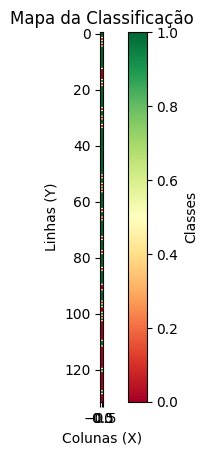

Treinamento e validação completos. Resultados salvos em /home/andre/Documentos/SpotSat/data/processed/model/


In [11]:
main()